In [1]:
from utils.mnist import MNIST, MNIST_NORMALIZATION
from utils.emnist import EMNIST
from utils.fmnist import FashionMNIST
from core.cnn import simple_cnn
from core.maha import maha_distance
from torchvision import datasets,transforms
import torch
import numpy as np
from utils.score import plot
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,mode = 'all',transform=tf)
test_id = MNIST('./dataset/', download=True,mode = 'all',transform=tf,train=False)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = simple_cnn(y_dim = 10).to('cuda:0')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


### Training

In [4]:
for e in range(5):
    for image,label in train_loader:
        out = model(image.to('cuda'))
        # print(out.shape,label)
        loss = criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.1447, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1320, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0842, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward>)


### Test Accuracy

In [5]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9856


### Uncertainty

In [6]:
model.eval()
id_score_ms = []
id_score_en = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out = model(image.to('cuda'))
        out = torch.softmax(out,dim=-1)
        en = torch.sum(-out*torch.log(out),dim=-1)
        logit,pred_logit = torch.max(out,dim=-1)
        id_score_ms += (1-logit).cpu().numpy().tolist()
        id_score_en += en.cpu().numpy().tolist()
id_score_ms = np.asarray(id_score_ms)
id_score_en = np.asanyarray(id_score_en)
print(id_score_ms.mean(),id_score_en.mean())

near_ood_score_ms = []
near_ood_score_en = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_near_ood_loader:
        out = model(image.to('cuda'))
        out = torch.softmax(out,dim=-1)
        en = torch.sum(-out*torch.log(out),dim=-1)
        logit,pred_logit = torch.max(out,dim=-1)
        near_ood_score_ms += (1-logit).cpu().numpy().tolist()
        near_ood_score_en += en.cpu().numpy().tolist()
near_ood_score_ms = np.asarray(near_ood_score_ms)
near_ood_score_en = np.asanyarray(near_ood_score_en)
print(near_ood_score_ms.mean(),near_ood_score_en.mean())

far_ood_score_ms = []
far_ood_score_en = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_far_ood_loader:
        out = model(image.to('cuda'))
        out = torch.softmax(out,dim=-1)
        en = torch.sum(-out*torch.log(out),dim=-1)
        logit,pred_logit = torch.max(out,dim=-1)
        far_ood_score_ms += (1-logit).cpu().numpy().tolist()
        far_ood_score_en += en.cpu().numpy().tolist()
far_ood_score_ms = np.asarray(far_ood_score_ms)
far_ood_score_en = np.asanyarray(far_ood_score_en)
print(far_ood_score_ms.mean(),far_ood_score_en.mean())

0.016193701714277267 0.053843225193963826
0.2544163099475778 0.7092955565623856
0.42053973273038864 1.1901365558551993


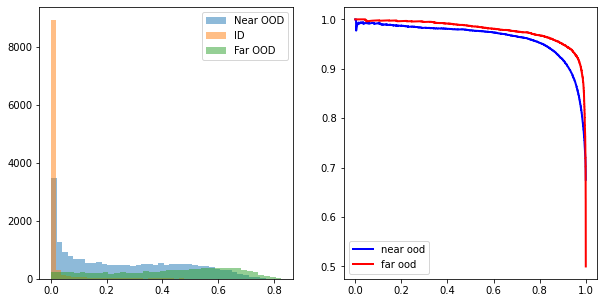

Near AUROC:0.9366744254807693, Far AUROC: 0.9815996650000002


In [7]:
auroc = plot(id_score_ms,near_ood_score_ms,far_ood_score_ms,name='relative-maha',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

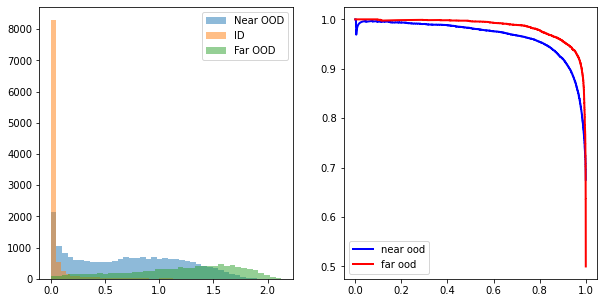

Near AUROC:0.9399112908653847, Far AUROC: 0.9858952900000001


In [8]:
auroc = plot(id_score_en,near_ood_score_en,far_ood_score_en,name='relative-maha',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration

In [9]:
from sklearn.calibration import calibration_curve

In [31]:
def calculate_ece(y_true,score,prob_true,prob_pred):
    bin_total = []
    prob_pred = np.asarray(prob_pred)
    for e, pred in enumerate(prob_pred):
        try:
            bm = ((score>pred) & (score<prob_pred[e+1])).sum()
        except:
            bm = ((score>pred)).sum()
        bin_total.append(bm)
    bin_total = np.asarray(bin_total)
    ece = np.sum(np.abs(prob_true - prob_pred) * (bin_total / len(y_true)))
    return ece*100

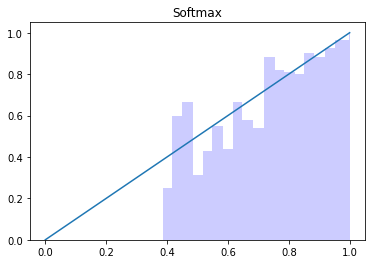

In [32]:
prob_true, prob_pred = calibration_curve(y_true,1-id_score_ms, n_bins=30)
plt.figure()
plt.title("Softmax")
for e,(t,p) in enumerate(zip(prob_true,prob_pred)):
    try:
        width = prob_pred[e+1] - p
    except:
        width = 1-p
    plt.bar(p,t,width,align = 'edge',color=[0,0,1,0.2])
plt.plot([0,1],[0,1])
plt.show()


In [35]:
ece = calculate_ece(y_true,1-id_score_ms,prob_true,prob_pred)
print("ECE(%): ",ece)

ECE(%):  0.6840462702853184


In [15]:

prob_true, prob_pred = calibration_curve(y_true,id_score_en, n_bins=30)
plt.figure()
plt.title("Entropy")
for e,(t,p) in enumerate(zip(prob_true,prob_pred)):
    try:
        width = prob_pred[e+1] - p
    except:
        width = 1-p
    plt.bar(p,t,width,align = 'edge',color=[0,0,1,0.2])
plt.plot([0,1],[0,1])
plt.show()


ValueError: y_prob has values outside [0, 1].